![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)

# Hybrid Search for E-Commerce using CLIP model of OpenAI

This project using the CLIP model of OpenAI which incling text(description of the image) and the image for vectorizing. In addition I use Pinecone which is a vector database to store the vector of each data line.

## Architecture
* Using BM25 to vectorize text to sprase vector, if you are confuse about the sprase vector click ....
* Using clip-ViT-B-32 to vectorize the image to 512 dimensions vector which store the fetures of the image.
Store these vectors in Pinecone database




In [1]:
!pip install -qU datasets transformers sentence-transformers \
                 pinecone-client==3.1.0 pinecone-text

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 21.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.1/227.1 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.0/211.0 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 MB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.6/67.6 kB 5.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 48.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into acc

In [2]:
# Connect to google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
from pinecone import Pinecone

# initialize connection to pinecone (get API key at app.pinecone.io)
api_key = 'd9ba3ead-959b-40ff-985b-9532080af87a'

# configure client
pc = Pinecone(api_key=api_key)

In [4]:
from pinecone import ServerlessSpec

cloud = os.environ.get('PINECONE_CLOUD') or 'aws'
region = os.environ.get('PINECONE_REGION') or 'us-east-1'

spec = ServerlessSpec(cloud=cloud, region=region)

In [5]:
# choose a name for your index
index_name = "hybrid-image-search"

In [6]:
import time

# check if index already exists (it shouldn't if this is first time)
if index_name not in pc.list_indexes().names():
    # if does not exist, create index
    pc.create_index(
        index_name,
        dimension=512,
        metric='dotproduct',
        spec=spec
    )
    # wait for index to be initialized
    while not pc.describe_index(index_name).status['ready']:
        time.sleep(1)

# connect to index
index = pc.Index(index_name)
# view index stats
index.describe_index_stats()

{'dimension': 512,
 'index_fullness': 0.0,
 'namespaces': {'': {'vector_count': 44072}},
 'total_vector_count': 44072}

In [7]:
# connect to index
index = pc.Index(index_name)
# view index stats
index.describe_index_stats()

{'dimension': 512,
 'index_fullness': 0.0,
 'namespaces': {'': {'vector_count': 44072}},
 'total_vector_count': 44072}

## Load dataset

In [8]:


from datasets import load_dataset

# load the dataset from huggingface datasets hub
fashion = load_dataset(
    "ashraq/fashion-product-images-small",
    split="train"
)
fashion

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/44072 [00:00<?, ? examples/s]

Dataset({
    features: ['id', 'gender', 'masterCategory', 'subCategory', 'articleType', 'baseColour', 'season', 'year', 'usage', 'productDisplayName', 'image'],
    num_rows: 44072
})

In [9]:
# assign the images and metadata to separate variables
images = fashion["image"]
metadata = fashion.remove_columns("image")

In [14]:
from pinecone_text.sparse import BM25Encoder

bm25 = BM25Encoder()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [15]:
bm25.fit(metadata['productDisplayName'])

  0%|          | 0/44072 [00:00<?, ?it/s]

In [16]:
import pickle

with open('/content/drive/MyDrive/Recommendation/bm25_model.pkl', 'wb') as f:
    pickle.dump(bm25, f)

In [17]:
# Open model bm25

with open('/content/drive/MyDrive/Recommendation/bm25_model.pkl', 'rb') as f:
    bm25 = pickle.load(f)

In [18]:
query = "Turtle Check Men Navy Blue Shirt"
tokenized_query = query.split()

doc_scores = bm25.encode_documents(query)

print(doc_scores)

{'indices': [23789636, 1830646559, 632192512, 931643408, 3905155331, 3828986392], 'values': [0.4449638258432887, 0.4449638258432887, 0.4449638258432887, 0.4449638258432887, 0.4449638258432887, 0.4449638258432887]}


### Hybrid Scale of search by merging dense_vector and sparse_vector


In [19]:
def hybrid_scale(dense, sparse, alpha: float):
    """Hybrid vector scaling using a convex combination

    alpha * dense + (1 - alpha) * sparse

    Args:
        dense: Array of floats representing
        sparse: a dict of `indices` and `values`
        alpha: float between 0 and 1 where 0 == sparse only
               and 1 == dense only
    """
    if alpha < 0 or alpha > 1:
        raise ValueError("Alpha must be between 0 and 1")
    # scale sparse and dense vectors to create hybrid search vecs
    hsparse = {
        'indices': sparse['indices'],
        'values':  [v * (1 - alpha) for v in sparse['values']]
    }
    hdense = [v * alpha for v in dense]
    return hdense, hsparse

# Test

## Load pre-trained model

In [20]:
from sentence_transformers import SentenceTransformer
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# load a CLIP model from huggingface
model = SentenceTransformer(
    'sentence-transformers/clip-ViT-B-32',
    device=device
)
model

modules.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/1.91k [00:00<?, ?B/s]

0_CLIPModel/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

0_CLIPModel/config.json:   0%|          | 0.00/4.03k [00:00<?, ?B/s]

0_CLIPModel/special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

0_CLIPModel/tokenizer_config.json:   0%|          | 0.00/604 [00:00<?, ?B/s]

0_CLIPModel/vocab.json:   0%|          | 0.00/961k [00:00<?, ?B/s]

0_CLIPModel/preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

SentenceTransformer(
  (0): CLIPModel()
)

In [21]:
from IPython.core.display import HTML
from io import BytesIO
from base64 import b64encode

# function to display product images
def display_result(image_batch):
    figures = []
    for img in image_batch:
        b = BytesIO()
        img.save(b, format='png')
        figures.append(f'''
            <figure style="margin: 5px !important;">
              <img src="data:image/png;base64,{b64encode(b.getvalue()).decode('utf-8')}" style="width: 90px; height: 120px" >
            </figure>
        ''')
    return HTML(data=f'''
        <div style="display: flex; flex-flow: row wrap; text-align: center;">
        {''.join(figures)}
        </div>
    ''')

In [22]:
query = "t-shirt with flower image"

# create sparse and dense vectors
sparse = bm25.encode_queries(query)
dense = model.encode(query).tolist()


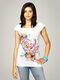
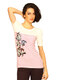
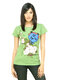
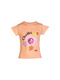
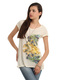
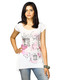
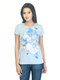
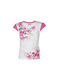
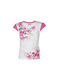
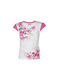
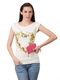
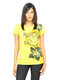
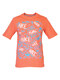
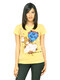

In [23]:
# scale sparse and dense vectors
hdense, hsparse = hybrid_scale(dense, sparse, alpha=0.05)
# search
result = index.query(
    top_k=14,
    vector=hdense,
    sparse_vector=hsparse,
    include_metadata=True
)
# used returned product ids to get images
imgs = [images[int(r["id"])] for r in result["matches"]]
# display the images
display_result(imgs)

In [24]:
for x in result["matches"]:
    print(x["metadata"]['productDisplayName'])

Jealous 21 Women's Flower Printed White Top
Jealous 21 Women White Flower Top Purple Stripes Top
Little Miss Women Flower Green T-shirt
Chhota Bheem Kids Girl Chutki Flowers Orange Tshirt
Allen Solly Woman Cream Top
Jealous 21 Women's Pink Flowers Offwhite Top
Wrangler Women Water Flower Blue T-shirt
Gini and Jony Girls Knits White Top
Gini and Jony Girls Knits White Top
Gini and Jony Girls Knits White Top
French Connection Women White T-shirt
Little Miss Women Sunshine Yellow T-shirt
Nike Men Brushed Orange T-shirt
Little Miss Women Flower Yellow Tshirt
